# Predicting Dino Stats

In this section, we will predict features of dinosaurs such as their speed and lifespans based on other features such as height and weight. 

To do this, we'll train a simple machine learning model using pytorch on modern animal data and use that data to predict information about their ancient ancestors.

## Imports

Let's start with all the imports that we need in order to do this.

In [533]:
%matplotlib widget
import matplotlib.pyplot as plt     # plotting
from matplotlib import cm           # colormaps
import pandas as pd                 # data processing, CSV file I/O
import numpy as np                  # linear algebra
from tqdm import tqdm               # fancy progress bars

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

## Data Cleaning

In [534]:
# load in animal data
animal_df = pd.read_csv('Datasets/Animal-Info.csv')

### Cleaning Methods

Here are some functions that we will use to clean our animal info data

In [585]:

def remove_na(df):
    temp = df
    for column in temp.columns:
        temp = temp[(temp[column] != 'Varies') & (temp[column] != 'Not Applicable')]
    return temp

def clean_column(item):
    item = item.replace(',', '')
    if item[-1] == 'm':
        split = item.split()
        item = f'{' '.join(split[:2])} {float(split[2][:-1])*100}'
    if item.count('tons') > 0:
        split = item.split()
        item = f'{' '.join(split[:2])} {float(split[2])*1000}'
        
    out = 0
    split = item.replace(' ', '-').split('-')
    if item.count('-') > 0:
        out = (float(split[0]) + float(split[1]))/2
    if item.count('Up to') > 0:
        out = float(item.split()[-1])/2
    if split[-1] == 'months':
        out *= 30
    if split[-1] == 'weeks':
        out *= 7
    only_nums = lambda x: ''.join([i for i in x if i.isnumeric() or i == '.'])
    
    return out if out else float(only_nums(item))

def z_score(x, based_on=None):
    if based_on is None: based_on = x
    return (x - np.mean(based_on))/np.std(based_on)

def normalize(nums, scale=np.log):
    nums = scale(nums)
    return z_score(nums)

Now let's choose what information we want to clean and actually clean the data

In [588]:
clean_animals = remove_na(animal_df)
columns_to_clean = ['Height (cm)', 'Weight (kg)', 'Lifespan (years)', 
                    'Average Speed (km/h)', 'Top Speed (km/h)', 
                    'Gestation Period (days)']

for column in columns_to_clean:
    category = ' '.join(column.split()[:-1])
    clean_animals = clean_animals.assign(**{category: clean_animals[column].apply(clean_column)})
    clean_animals = clean_animals.assign(**{f'Normal {category}': normalize(clean_animals[category])})

clean_animals.to_csv('Datasets/Clean-Animal-Info.csv')

## Machine Learning

### Data Loading

Now let's load in the data that we're going to train our model on.

In [589]:
inputs = ['Normal Height', 'Normal Weight']
outputs = ['Lifespan', 'Average Speed', 'Top Speed', 'Gestation Period']
input_tensors = torch.tensor(np.array(clean_animals[inputs]), dtype=torch.float)
output_tensors = torch.tensor(np.array(clean_animals[outputs]), dtype=torch.float)
X_train, X_test, Y_train, Y_test = train_test_split(input_tensors, output_tensors, test_size=0.1)

Let's also define some hyperparameters and choose a device to train our model.

In [590]:
BATCH_SIZE = 8
LAYERS = [len(inputs), 10, 10, 10, len(outputs)]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Now we'll create custom dataset to hold the data and then load in our data into pytorch dataloaders.

In [591]:
class CustomDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs
        
    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self, idx):
        input = self.inputs[idx]
        output = self.outputs[idx]
        return input, output

In [592]:
train_ds = CustomDataset(X_train, Y_train)
test_ds = CustomDataset(X_test, Y_test)

train_dl = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE)

### Training

Here is our nueral network class which consists of linear layers with the non-linear ReLU activation function. We also added dropout layers in order to prevent overfitting.

In [593]:
class Network(nn.Module):
    def __init__(self, dims, stack=None):
        super().__init__()
        if stack:
            self.stack = stack
        else:
            self.stack = nn.Sequential(nn.Dropout(p=0.1))
            for i in range(len(dims)-1):
                self.stack.append(nn.Linear(dims[i], dims[i+1]))
                if i != len(dims)-2:
                    self.stack.append(nn.ReLU())
                    self.stack.append(nn.Dropout(p=0.05))
                    
    def forward(self, x):
        x = x.view(-1, len(inputs))
        return self.stack(x)

Now let's create the functions we need for the training loop.

In [594]:
def run(X, Y, model, loss):
    X, Y = X.to(device), Y.to(device)
    y_pred = model(X)
    y_pred, Y = y_pred.cpu(), Y.cpu()
    error = loss(y_pred, Y)
    return error

def train_epoch(model, optimizer, loss):
    model.train()
    errors = []

    for X, Y in train_dl:
        error = run(X, Y, model, loss)
        errors.append(error.item())

        optimizer.zero_grad()
        error.backward()
        optimizer.step()

    return np.mean(errors)

def evaluate(model, loss):
    model.eval()
    errors = []
    
    with torch.no_grad():
        for X, Y in test_dl:
            error = run(X, Y, model, loss)
            errors.append(error.item())
    
    return np.mean(errors)

Here's an additional function that we're using in order to visualize the inputs and outputs of the nueral network.

In [595]:
def show_plot(model, x, y, z, show_pred=False, show_terrain=False, show_all=False):
    fig = plt.figure()
    norm_x, norm_y, norm_z = f'Normal {x}', f'Normal {y}', f'Normal {z}'
    
    loop_len = range(len(outputs)) if show_all else [outputs.index(z)]
    for i in loop_len:
        if show_all: ax = fig.add_subplot(2, 2, i+1, projection='3d')
        else: ax = fig.add_subplot(projection='3d')

        if show_pred:
            if show_terrain:
                X = np.arange(-5, 5, 0.25)
                Y = np.arange(-5, 5, 0.25)
                grid_X, grid_Y = np.meshgrid(X, Y)
                grid_X = torch.tensor(grid_X, dtype=torch.float)
                grid_Y = torch.tensor(grid_Y, dtype=torch.float)
            
            model.eval()
            with torch.no_grad():
                if show_terrain:
                    Z = model(torch.stack((grid_X, grid_Y), dim=2).reshape(-1, 2)).numpy()
                    ax.plot_surface(grid_X, grid_Y, Z[:, i].reshape(len(X), len(Y)), cmap=cm.coolwarm)
                else:
                    Z = model(torch.tensor(np.array(clean_animals[[norm_x, norm_y]]), dtype=torch.float)).numpy()
                    ax.scatter(clean_animals[norm_x], clean_animals[norm_y], Z[:, i], marker='o')
            
        ax.scatter(clean_animals[norm_x], clean_animals[norm_y], clean_animals[z], marker='^', color='orange')
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_zlabel(z)

    plt.show()

In [596]:
def Train(learn_rate=0.001, epochs=30, plot_info=True):
    network = Network(LAYERS)
    network = network.to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(network.parameters(), lr = learn_rate, weight_decay=1e-5)

    train_errors = []
    test_errors = []

    for epoch in (bar := tqdm(range(epochs))):
        batch_error = train_epoch(network, optimizer, loss_fn)
        train_errors.append(batch_error)

        test_error = evaluate(network, loss_fn)
        test_errors.append(test_error)
        
        bar.set_description(f'Error: {test_error:.2f}')

    if plot_info:
        fig, error = plt.subplots(figsize=(14, 5))

        error.plot(train_errors)
        error.plot(test_errors)
        error.legend(['Train', 'Test'])
        error.set_xlabel('Epochs')
        error.set_ylabel('Error')
        error.set_title(f'Train Error: {train_errors[-1]:.2f} Test Error: {test_errors[-1]:.2f}')

    return network

Error: 15195.41: 100%|██████████| 100/100 [00:01<00:00, 56.74it/s]


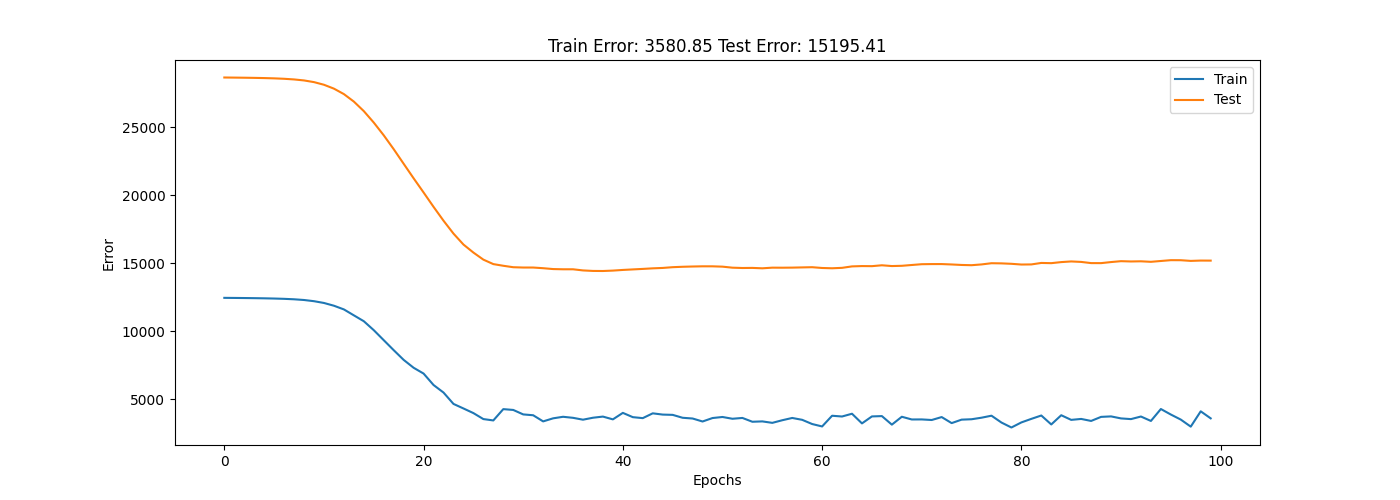

In [597]:
network = Train(epochs=100)

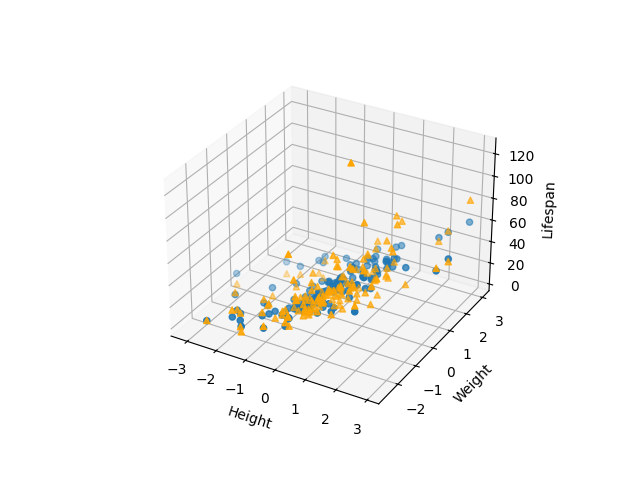

In [601]:
show_plot(network, 'Height', 'Weight', 'Lifespan', show_pred=True)

In [604]:
dinos = pd.read_csv('Datasets\jurassicparkwithweights.csv')
clean_dinos = dinos.drop(columns='Unnamed: 0').set_index('name')

In [617]:
def pred_stat(dino, stat, model):
    METERS2CM = 100
    length2height = lambda length: 0.53*length - 0.73   # From Regression
    
    info = clean_dinos[['length', 'weight']].loc[dino]
    info[0] = length2height(info[0])
    
    norm_height = z_score(info[0]*METERS2CM, based_on=clean_animals['Height'])
    norm_weight = z_score(info[1], based_on=clean_animals['Weight'])
    inputs = torch.tensor([norm_height, norm_weight], dtype=torch.float)
    predictions = model(inputs).squeeze()
    return predictions[outputs.index(stat)].item()
    
pred_stat('velociraptor', 'Lifespan', network)

17.48764419555664